<a href="https://colab.research.google.com/github/libra3910/diveintocode-ml/blob/master/sprint_deep_learning_conv2_newral_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2次元の畳み込みニューラルネットワークスクラッチ

In [ ]:
import numpy as np

In [ ]:
np.set_printoptions(threshold=100000)

### ミニバッチ

In [ ]:
# Utilityクラス
# GetMiniBatch
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 20, seed=0):
        
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        
        return self._stop
    
    def __getitem__(self,item):
        
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        
        return self._X[p0:p1], self._y[p0:p1]   
    
    def __iter__(self):
        
        self._counter = 0
        
        return self
    
    def __next__(self):
        
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        
        return self._X[p0:p1], self._y[p0:p1]

### 全結合層

In [ ]:
# Initializerクラス
# SimpleInitializer 【問題2】初期化方法のクラス化
class SimpleInitializer:
    
    def __init__(self, sigma, seed=0):
        
        self.sigma = sigma
        self.seed = seed
        np.random.seed(self.seed)
        
    def W(self, n_nodes1, n_nodes2):
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

In [ ]:
# Xavier
class Xavier:
    """
    初期値を正規分布化するため、前層のノード数の根で除算する。
    活性化関数がシグモイド関数やハイパボリックタンジェント関数の場合に適用。
    
    """
    def __init__(self, sigma, seed=0):
        
        self.sigma = sigma
        self.seed = seed
        np.random.seed(self.seed)
        
    def W(self, n_nodes1, n_nodes2):
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2) * (1 / np.sqrt(n_nodes1))
        
        return W
    
    def B(self, n_nodes2):
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

In [ ]:
# He
class He:
    """
    （2×前層のノード数の根）で除算する。
    活性化関数がReLU関数の場合に適用。
    
    """
    def __init__(self, sigma, seed=0):
        
        self.sigma = sigma
        self.seed = seed
        np.random.seed(self.seed)
        
    def W(self, n_nodes1, n_nodes2):
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2) * (2 / np.sqrt(n_nodes1))
        
        return W
    
    def B(self, n_nodes2):
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

In [ ]:
# Optimizerクラス
# SGD
class SGD:

    def __init__(self, lr):
        
        self.lr = lr
        
    def update(self, layer):

        #layer.W -= self.lr * np.dot(layer.X.T, layer.dA)
        #layer.B -= self.lr * np.sum(layer.dA, axis=0)
        layer.W -= self.lr * layer.dAW
        layer.B -= self.lr * layer.dAB
        
        return layer

In [ ]:
# AdaGrad
class AdaGrad:

    def __init__(self, lr):
        
        self.lr = lr
        self.HiW = 0
        self.HiB = 0
        
    def update(self, layer):
        
        self.HiW += layer.dAW ** 2
        self.HiB += layer.dAB ** 2
        
        layer.W -= self.lr * (1 / (np.sqrt(self.HiW) + 1e-7)) * layer.dAW
        layer.B -= self.lr * (1 / (np.sqrt(self.HiB) + 1e-7)) * layer.dAB
        
        return layer

In [ ]:
# Layerクラス
# FC
class FC:

    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):

        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.optimizer = optimizer

        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する

        self.W = self.initializer.W(n_nodes1, n_nodes2)
        self.B = self.initializer.B(n_nodes2)
        self.X = None
        self.dA = None
        
    def forward(self, X):

        self.X = X
        A = np.dot(self.X, self.W) + self.B
        return A
    
    def backward(self, dA):

        self.dA = dA

        self.dAW = np.dot(self.X.T, self.dA)
        self.dAB = np.sum(self.dA, axis=0)
        
        dz = np.dot(dA, self.W.T)
        
        self = self.optimizer.update(self)

        return dz

In [ ]:
# ReLU
class ReLU:

    def __init__(self):

        self.A = None
    
    def forward(self, X):
  
        self.A = np.copy(X)
        
        return np.maximum(0, X)
        
    def backward(self, dA):

        return np.where(self.A > 0, dA, 0)

In [ ]:
# Tanh
class Tanh:

    def __init__(self):

        pass

    def forward(self, X):

        self.Z = (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))
        return self.Z
        
    def backward(self, dA):
        
        dA2 = dA * (1 - self.Z**2)
        
        return dA2

In [ ]:
# Softmax
class Softmax:
    
    def __init__(self):
        
        pass
    
    def forward(self, X):
        
        dz = np.exp(X) / np.sum(np.exp(X), axis=1, keepdims=True)
        return dz
    
    def backward(self, Z3, y):

        y_one_hot = (y.reshape(-1,1)==np.arange(10))
        dza = (Z3 - y) / y.shape[0]
        #【問題3】交差エントロピー誤差の実装
        L = np.sum(np.mean(-(y_one_hot * Z3), axis=0))
        C = np.sum(np.array(dza).argmax(axis=1) == y)
        
        return dza, L, C

In [ ]:
# Calculates log(sum(exp(x)))
class logsumexp:
    
    def __init__(self):

        pass

    def forward(self, X):
        
        xmax = X.max(axis=1, keepdims=True)
        self.Z = np.log(np.exp(X - xmax).sum(axis=1, keepdims=True)) + xmax
        
        return self.Z

    def backward(self, Z3, log_Z3, y):

        y_one_hot = (y.reshape(-1,1)==np.arange(10)).reshape(Z3.shape)
        dza = (Z3 - y_one_hot) / y_one_hot.shape[0]

        L = np.sum(np.mean(-(y_one_hot * log_Z3), axis=0))
        C = np.sum(Z3.argmax(axis=1) == y)
        
        return dza, L, C

### 畳み込み層¶

In [ ]:
# Initializerクラス
# SimpleInitializer 【問題2】初期化方法のクラス化
class SimpleInitializerConv2d:
    
    def __init__(self, sigma, seed=0):
        
        self.sigma = sigma
        self.seed = seed
        np.random.seed(self.seed)
        
    def W(self, out_channel, in_channel, filter_size_h, filter_size_w):
        
        W = self.sigma * np.random.randn(out_channel, in_channel, filter_size_h, filter_size_w)
        
        return W
    
    def B(self, out_channel):
        
        B = self.sigma * np.random.randn(out_channel)
        
        return B

In [ ]:
# 1次元畳み込み層
class SimpleConv2d:

    def __init__(self, out_channel, in_channel, filter_size_h, filter_size_w,
                padding_size_h = 0, padding_size_w = 0, stride_size_h = 1, stride_size_w = 1, 
                initializer = None, optimizer = None):
        
        self.padding_size_h = padding_size_h
        self.padding_size_w = padding_size_w
        self.stride_size_h = stride_size_h
        self.stride_size_w = stride_size_w
        self.initializer = initializer
        self.optimizer = optimizer
        
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する

        self.W = self.initializer.W(out_channel, in_channel, filter_size_h, filter_size_w)
        self.B = self.initializer.B(out_channel)
        self.X = None
        self.dA = None

    def N_out_H_W(X_h_shape, X_w_shape, W_h_shape, W_w_shape, pad_h, pad_w, strd_h, strd_w):
        N_out_h = int((X_h_shape + 2*pad_h - W_h_shape) / strd_h) + 1 # 【問題２】1次元畳み込み後の出力サイズの計算:高さ
        N_out_w = int((X_w_shape + 2*pad_w - W_w_shape) / strd_w) + 1 # 【問題２】1次元畳み込み後の出力サイズの計算:幅
    
        return N_out_h, N_out_w

    def forward(self, X):
        
        self.X = X
        
        self.N_out_h, self.N_out_w =  N_out_H_W(X_h_shape=X.shape[2], X_w_shape=X.shape[3], W_h_shape=W.shape[2], W_w_shape=W.shape[3], 
                                      pad_h=0, pad_w=0, strd_h=1, strd_w=1)
        
        a = np.array([])

        for n1 in range(self.X.shape[0]):     # バッチ数分
            for n2 in range(self.X.shape[1]):     # 画像チャネル数分
                for f in range(self.W.shape[1]):  # フィルターの枚数分
                    for h in range(self.N_out_h):      # 縦のストライド
                        for w in range(self.N_out_w):  # 横のストライド
                            a = np.append(a, np.sum(self.X[n1, n2, h:h+self.W.shape[2], w:w+self.W.shape[3]] * self.W[n1,f]) + self.B[n1])

        a = a.reshape(self.X.shape[0], self.X.shape[1], self.N_out_h, self.N_out_w)
        
        return a
        
    def backward(self, delta_a):
        
        # Xを更新
        self.aX = np.zeros((self.X.shape))
        for n1 in range(self.X.shape[0]):     # バッチ数分
            for n2 in range(self.X.shape[1]):     # 画像チャネル数分
                for f in range(self.W.shape[1]):      # フィルターの枚数分
                    for h in range(self.N_out_h):         # 縦のストライド
                        for w in range(self.N_out_w):         # 横のストライド
                            self.aX[n1, n2, h:h+self.W.shape[2], w:w+self.W.shape[3]] += self.W[n1, f, 0:self.W.shape[2], 0:self.W.shape[3]] * delta_a[n1, f, h, w]

        # Wを更新
        self.dAW = np.zeros((self.W.shape))
        for n1 in range(self.X.shape[0]):     # バッチ数分
            for n2 in range(self.X.shape[1]):     # 画像チャネル数分
                for f in range(self.W.shape[1]):      # フィルターの枚数分
                    for h in range(self.N_out_h):         # 縦のストライド
                        for w in range(self.N_out_w):         # 横のストライド
                            self.dAW[n1, f] += self.X[n1, n2, h:h+self.W.shape[2], w:w+self.W.shape[3]] * delta_a[n1, f, h, w]

        # Bを更新
        self.dAB = np.zeros((self.W.shape[0]))
        for f in range(self.W.shape[0]):
            self.dAB[f] = np.sum(delta_a[f])

        self = self.optimizer.update(self)
        
        return self.aX
            

In [ ]:
# MaxPooling
class MaxPooling:
    
    def __init__(self, strd_h=2, strd_w=2):
        
        self.strd_h = strd_h
        self.strd_w = strd_w

    def N_out_H_W(X_h_shape, X_w_shape, W_h_shape, W_w_shape, pad_h, pad_w, strd_h, strd_w):

        N_out_h = int((self.X_h_shape + 2*pad_h - W_h_shape) / strd_h) + 1 # 【問題２】1次元畳み込み後の出力サイズの計算:高さ
        N_out_w = int((X_w_shape + 2*pad_w - W_w_shape) / strd_w) + 1 # 【問題２】1次元畳み込み後の出力サイズの計算:幅
        
        return N_out_h, N_out_w
    
    def forward(self, X):
        
        self.X = X
        
        self.N_out_h, self.N_out_w = N_out_H_W(X_h_shape=self.X.shape[2], X_w_shape=self.X.shape[3], W_h_shape=2, W_w_shape=2, 
                                     pad_h=0, pad_w=0, strd_h=self.strd_h, strd_w=self.strd_w)
        
        self.a_MP = np.zeros((self.X.shape[0], self.X.shape[1], int(self.X.shape[2]/self.strd_h), int(self.X.shape[3]/self.strd_w)))
        self.X_MPi = np.array([])
        for n1 in range(X.shape[0]):     # バッチ数分
            for n2 in range(self.X.shape[1]):     # 画像チャネル数分
                for h in range(self.N_out_h):         # 縦のストライド
                    for w in range(self.N_out_w):         # 横のストライド
                        self.a_MP[n1, n2, h, w] = np.max(self.X[n1 , n2 , h*self.strd_h : h*self.strd_h+self.strd_h , w*self.strd_w : w*self.strd_w+self.strd_w])
                        MPi_h = np.argmax(self.X[n1 , n2 , h*self.strd_h : h*self.strd_h+self.strd_h , w*self.strd_w : w*self.strd_w+self.strd_w]) // self.strd_h + h*self.strd_h
                        MPi_w = np.argmax(self.X[n1 , n2 , h*self.strd_h : h*self.strd_h+self.strd_h , w*self.strd_w : w*self.strd_w+self.strd_w]) %  self.strd_w + w*self.strd_w
                        self.X_MPi = np.append(self.X_MPi, [MPi_h, MPi_w]).astype(int)

        self.X_MPi = self.X_MPi.reshape(self.X.shape[0], self.X.shape[1], self.N_out_h, self.N_out_w, 2)
        return self.a_MP

    def backward(self, aX):
        
        self.aX = aX

        self.X_MP = np.zeros(self.X.shape)
        for n1 in range(self.X.shape[0]):     # バッチ数分
            for n2 in range(self.X.shape[1]):     # 画像チャネル数分
                for h in range(0, self.X_MPi.shape[2]):         # 縦のストライド
                    for w in range(0, self.X_MPi.shape[3]):
                        self.X_MP[n1, n2, int(self.X_MPi[n1, n2, h, w, 0]), int(self.X_MPi[n1, n2, h, w, 1])] = self.aX[n1, n2, h, w]
                    
        return self.X_MP

In [ ]:
# 平準化
class Flatten:

    def __init__(self):
        
        pass

    def forward(self, X):

        self.Xshape = X.shape
        X = X.reshape(X.shape[0], X.shape[1], -1)
        
        return X
        
    def backward(self, X):
        
        X = X.reshape(self.Xshape)
        
        return X

### 学習および推定

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# Tranerクラス
class ScratchDeepNeuralNetrowkClassifier():
    """
    Trainerクラスの定義
    
    """
    # self.sigma : ガウス分布の標準偏差
    # self.lr : 学習率
    # self.n_nodes1 : 1層目のノード数
    # self.n_nodes2 : 2層目のノード数
    # self.n_output : 出力層のノード数
    
    batch_size = 20
    sigma = 0.01
    n_features = 169
    n_nodes1 = 400
    n_nodes2 = 200
    n_output = 10
    lr = 0.01

    def __init__(self, seed=0, verbose = True, verbose2 = False):
        
        self.seed = 0
        self.verbose = verbose
        self.verbose2 = verbose2

    def fit(self, X, y, X_val=None, y_val=None, pinit="Initializer", pact1="Tanh", pact2="logsumexp", popt="SGD",
            cinit = "InitializerConv2d", cact = "ReLU", copt = "SGD", MaxPool = True, Flat = True, 
            out_channel = 20, in_channel = 1, filter_size_h = 3, filter_size_w = 3, padding_size_h = 0, padding_size_w = 0, 
            stride_size_h = 1, stride_size_w = 1, pooling_size_h = 2, pooling_size_w = 2):

        # 畳み込み層　初期化、学習用の各関数を定義
        # 初期化関数
        if cinit == "InitializerConv2d":
            initializerConv2d =SimpleInitializerConv2d(self.sigma, self.seed)
        
        # 最適化関数
        if copt == "SGD":
            optimizerConv2d = SGD(self.lr)
        
        # 活性化関数
        if cact == "ReLU":
            self.activationConv2d = ReLU()
        
        # 学習用関数初期化
        if copt == "SGD":
            self.Conv2d = SimpleConv2d(out_channel, in_channel, filter_size_h, filter_size_w, padding_size_h, padding_size_w,
                                       stride_size_h, stride_size_w, initializerConv2d, optimizerConv2d)
        
        # MaxPooling関数
        if MaxPool:
            self.MaxPooling = MaxPooling(pooling_size_h, pooling_size_w)
        
        # 平滑化関数
        if Flat:
            self.Flatten = Flatten()
       
        # 全結合層　初期化、最適化、活性化、学習用の各関数を定義
        # 初期化関数
        if pinit == "Initializer":
            initializer = SimpleInitializer(self.sigma, self.seed)
        elif pinit == "Xavier":
            initializer = Xavier(self.sigma, self.seed)
        elif pinit == "He":
            initializer = He(self.sigma, self.seed)
        
        # 最適化関数
        if popt == "SGD":
            optimizer = SGD(self.lr)
        elif popt == "AdaGrad":
            optimizer1 = AdaGrad(self.lr) 
            optimizer2 = AdaGrad(self.lr) 
            optimizer3 = AdaGrad(self.lr) 
        
        # 活性化関数1
        if pact1 == "Tanh":
            self.activation1 = Tanh()
            self.activation2 = Tanh()
        if pact1 == "ReLU":
            self.activation1 = ReLU()
            self.activation2 = ReLU()

        # 活性化関数2
        if pact2 == "logsumexp":
            self.activation3 = logsumexp()
        elif pact2 == "Softmax":
            self.activation3 = Softmax()
        
        # 学習用関数初期化
        if popt == "SGD":
            self.FC1 = FC(self.n_features, self.n_nodes1, initializer, optimizer) # W1: (169, 400)
            self.FC2 = FC(self.n_nodes1, self.n_nodes2, initializer, optimizer) # W2: (400, 200) 
            self.FC3 = FC(self.n_nodes2, self.n_output, initializer, optimizer) # W3: (200, 10)
        elif popt == "AdaGrad":
            self.FC1 = FC(self.n_features, self.n_nodes1, initializer, optimizer1) # W1: (782, 400)
            self.FC2 = FC(self.n_nodes1, self.n_nodes2, initializer, optimizer2) # W2: (400, 200) 
            self.FC3 = FC(self.n_nodes2, self.n_output, initializer, optimizer3) # W3: (200, 10)            
        
        epoch = 20
        n_step_iteration_report = 1
        plot_data = []
        
        # Utility(epochごとに、全データ分ミニバッチを取得)
        for i in range(epoch):

            sum_of_loss = 0
            get_mini_batch = GetMiniBatch(X, y, batch_size = self.batch_size)
            for j, (mini_X_train, mini_y_train) in enumerate(get_mini_batch):
                
                mini_X_train = mini_X_train.reshape(out_channel, in_channel, 28, 28)
                
                # 畳み込み層　学習用Forward Propergation
                C1  = self.Conv2d.forward(mini_X_train)
                ZC1 = self.activationConv2d.forward(C1)

                # 畳み込み層　Maxpooling
                M1 = self.MaxPooling.forward(ZC1)
                
                # 畳み込み層　平滑化
                ZC1 = self.Flatten.forward(M1)
                ZC1 = ZC1.reshape(out_channel, ZC1.shape[-1])
                
                # 全結合層　学習用Forward Propergation
                A1 = self.FC1.forward(ZC1)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                log_Z3 = A3 - self.activation3.forward(A3)
                Z3 = np.exp(log_Z3)
                
                # 全結合層　学習用Back Propergation
                dA3,L,C = self.activation3.backward(Z3, log_Z3, mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
                
                # 畳み込み層　平滑化Back Propergation
                dZ0 = dZ0.reshape(out_channel, in_channel, dZ0.shape[-1])
                dF0 = self.Flatten.backward(dZ0)
                
                # 畳み込み層　MaxPooling Back Propergation
                dM0 = self.MaxPooling.backward(dF0)
                
                # 畳み込み層　学習用Back Propergation
                dA0 = self.activationConv2d.backward(dM0)
                dZC = self.Conv2d.backward(dA0)
                
                # ログ出力
                sum_of_loss += L
                if self.verbose and (j + 1) % n_step_iteration_report == 0:
                    train_loss = sum_of_loss / n_step_iteration_report

                    # 検証用Forward Propergation、損失、Accuracy
                    #C1  = self.Conv1d.forward(X_val)
                    #ZC1 = self.activationConv1d.forward(C1)                    
                    #A1 = self.FC1.forward(ZC1)
                    #Z1 = self.activation1.forward(A1)
                    #A2 = self.FC2.forward(Z1)
                    #Z2 = self.activation2.forward(A2)
                    #A3 = self.FC3.forward(Z2)
                    #log_Z3 = A3 - self.activation3.forward(A3)
                    #Z3 = np.exp(log_Z3)

                    #dA3,val_loss,val_accuracy = self.activation3.backward(Z3, log_Z3, y_val)
                    
                    #print(f'epoch: {i+1}, iteration: {j+1}, train_loss: {train_loss:.3}, val_loss: {val_loss:.3}, accuracty: {val_accuracy / len(y_val):.3}')
                    print(f'epoch: {i+1}, iteration: {j+1}, train_loss: {train_loss:.3}, accuracy: {C / len(mini_y_train):.3}')
                    sum_of_loss = 0

                    iters_per_epoch = len(X_train) / self.batch_size
                    print("iters_per_epoch={}".format(iters_per_epoch))
                    #plot_data.append((i + (j + 1) / iters_per_epoch, train_loss, val_loss))
                    plot_data.append((i + (j + 1) / iters_per_epoch, train_loss))
                
            if self.verbose:
                #verboseをTrueにした際は学習過程などを出力する
                pass
                
                if self.verbose2:
                    print("epoch={}".format(i))
                    print("forward propergation")                    
                    print(" A1={}".format(A1))
                    print(" Z1={}".format(Z1))
                    print(" A2={}".format(A2))
                    print(" Z2={}".format(Z2))
                    print(" A3={}".format(A3))
                    print(" Z3={}".format(Z3))
                    print("back propergation")
                    print("dA3={}".format(dA3))                    
                    print("dZ2={}".format(dZ2))
                    print("dA2={}".format(dA2))
                    print("dZ1={}".format(dZ1))
                    print("dA1={}".format(dA1))
                    print("dA0={}".format(dA0)) 
                    
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            #epochs, train_loss, val_loss = zip(*plot_data)
            epochs, train_loss = zip(*plot_data)
            plt.plot(epochs, train_loss, color='r', label='train_loss')
            #plt.plot(epochs, val_loss, color='b', label='val_loss')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.show()

    def predict(self, X):

        C1  = self.Conv2d.forward(X)
        ZC1 = self.activationConv2d.forward(C1)
        M1 = self.MaxPooling.forward(ZC1)
        ZC1 = self.Flatten.forward(M1)
        ZC1 = ZC1.reshape(20, ZC1.shape[-1])
        A1 = self.FC1.forward(ZC1)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        log_Z3 = A3 - self.activation3.forward(A3)
        y_pred = log_Z3.argmax(axis=1)
        
        return y_pred

### 【問題7】学習と推定

In [ ]:
# データセットをダウンロードするコード
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
# 平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [ ]:
# 前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [ ]:
y_train_one_hot = (y_train.reshape(-1,1) == np.arange(10)).astype(np.float64)
y_test_one_hot = (y_train.reshape(-1,1) == np.arange(10)).astype(np.float64)
print(y_train.shape)
print(y_train_one_hot.shape)
print(y_train_one_hot.dtype)

(60000,)
(60000, 10)
float64


In [ ]:
def split_data(X, permutation, val_size_rate=0.90):
    X = X[permutation]
    val_size = int(len(X) * val_size_rate)
    val = X[:val_size]
    train = X[val_size:]
    return train, val

permutation = np.random.permutation(np.arange(len(X_train)))
X_train, X_val = split_data(X_train, permutation)
y_train, y_val = split_data(y_train, permutation)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(60, 784)
(60,)
(540, 784)
(540,)


epoch: 1, iteration: 1, train_loss: 2.3, accuracy: 0.1
iters_per_epoch=3.0
epoch: 1, iteration: 2, train_loss: 2.3, accuracy: 0.1
iters_per_epoch=3.0
epoch: 1, iteration: 3, train_loss: 2.3, accuracy: 0.05
iters_per_epoch=3.0
epoch: 2, iteration: 1, train_loss: 2.3, accuracy: 0.1
iters_per_epoch=3.0
epoch: 2, iteration: 2, train_loss: 2.3, accuracy: 0.1
iters_per_epoch=3.0
epoch: 2, iteration: 3, train_loss: 2.3, accuracy: 0.05
iters_per_epoch=3.0
epoch: 3, iteration: 1, train_loss: 2.3, accuracy: 0.1
iters_per_epoch=3.0
epoch: 3, iteration: 2, train_loss: 2.3, accuracy: 0.1
iters_per_epoch=3.0
epoch: 3, iteration: 3, train_loss: 2.3, accuracy: 0.05
iters_per_epoch=3.0
epoch: 4, iteration: 1, train_loss: 2.3, accuracy: 0.1
iters_per_epoch=3.0
epoch: 4, iteration: 2, train_loss: 2.3, accuracy: 0.1
iters_per_epoch=3.0
epoch: 4, iteration: 3, train_loss: 2.3, accuracy: 0.05
iters_per_epoch=3.0
epoch: 5, iteration: 1, train_loss: 2.3, accuracy: 0.1
iters_per_epoch=3.0
epoch: 5, iteration: 

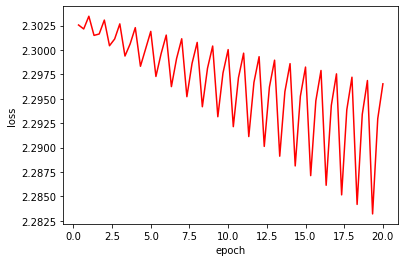

In [ ]:
dnnc = ScratchDeepNeuralNetrowkClassifier()
dnnc.fit(X_train, y_train, X_val=None, y_val=None, pinit="Initializer", pact1="Tanh", pact2="logsumexp", popt="SGD",
            cinit = "InitializerConv2d", cact = "ReLU", copt = "SGD", MaxPool = True, Flat = True, 
            out_channel = 20, in_channel = 1, filter_size_h = 3, filter_size_w = 3, padding_size_h = 0, padding_size_w = 0, 
            stride_size_h = 1, stride_size_w = 1, pooling_size_h = 2, pooling_size_w = 2)

In [ ]:
dnnc.predict(X_val[0:20].reshape(20, 1, 28, 28))

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
      dtype=int64)

### 【問題2】小さな配列での2次元畳み込み層の実験

In [ ]:
# Forward Propergation
# CNN2 のフォワードを流す時の入力データ
# (1,1,4,4)
X = np.array([[[[ 1,  2,  3,  4],
                [ 5,  6,  7,  8],
                [ 9, 10, 11, 12],
                [13, 14, 15, 16]]]])
# (2,3,3)
W = np.array([[[[ 0.,  0.,  0.],
               [ 0.,  1.,  0.],
               [ 0., -1.,  0.]],
              [[ 0.,  0.,  0.],
               [ 0., -1.,  1.],
               [ 0.,  0.,  0.]]]])
# (2)
B = np.array([0, 0])

In [ ]:
# Forward Propergation
# Xの要素の位置をストライドして計算
pad_h=0 #パディング
pad_w=0
strd_h=1 #ストライド
strd_w=1

N_out_h = int((X.shape[2] + 2*pad_h - W.shape[2]) / strd_h) + 1 # 【問題２】1次元畳み込み後の出力サイズの計算:高さ
N_out_w = int((X.shape[3] + 2*pad_w - W.shape[3]) / strd_w) + 1 # 【問題２】1次元畳み込み後の出力サイズの計算:幅

Yhat = np.array([])

for n1 in range(X.shape[0]):     # バッチ数分
    for n2 in range(X.shape[1]):     # 画像チャネル数分
        for f in range(W.shape[1]):      # フィルターの枚数分
            for h in range(N_out_h):         # 縦のストライド
                for w in range(N_out_w):         # 横のストライド
                    Yhat = np.append(Yhat, np.sum(X[n1, n2, h:h+W.shape[2], w:w+W.shape[3]] * W[n1, f]) + B[n1])

Yhat = Yhat.reshape(X.shape[0], X.shape[1], N_out_h, N_out_w, 2)

print(Yhat)

[[[[[-4. -4.]
    [-4. -4.]]

   [[ 1.  1.]
    [ 1.  1.]]]]]


In [ ]:
# Back Propergation
# CNN2 のフォワードを流す時の入力データ
# (2,2,2)
delta_a = np.array([[[[ -4,  -4],
                   [ 10,  11]],
                  [[  1,  -7],
                   [  1, -11]]]])
print(delta_a.shape)

(1, 2, 2, 2)


In [ ]:
# Back Propergation
# Xを更新
aX = np.zeros((X.shape))
for n1 in range(X.shape[0]):     # バッチ数分 = 1
    for n2 in range(X.shape[1]):     # 画像チャネル数分 = 1
        for f in range(W.shape[1]):      # フィルターの枚数分 = 2
            for h in range(N_out_h):         # 縦のストライド = 2
                for w in range(N_out_w):         # 横のストライド = 2
                    aX[n1, n2, h:h+W.shape[2], w:w+W.shape[3]] += W[n1, f, 0:W.shape[2], 0:W.shape[3]] * delta_a[n1, f, h, w]
print("aX={}".format(aX))
 
# Wを更新
aW = np.zeros((W.shape))
for n1 in range(X.shape[0]):     # バッチ数分 = 1
    for n2 in range(X.shape[1]):     # 画像チャネル数分 = 1
        for f in range(W.shape[1]):      # フィルターの枚数分 = 2
            for h in range(N_out_h):         # 縦のストライド = 2
                for w in range(N_out_w):         # 横のストライド = 2
                    aW[n1, f] += X[n1, n2, h:h+W.shape[2], w:w+W.shape[3]] * delta_a[n1, f, h, w]
                    
print("aW={}".format(aW))

# Bを更新
aB = np.zeros((W.shape[0]))
for f in range(W.shape[0]):
    aB[f] = np.sum(delta_a[f])
print("aB={}".format(aB))

aX=[[[[  0.   0.   0.   0.]
   [  0.  -5.   4.  -7.]
   [  0.  13.  27. -11.]
   [  0. -10. -11.   0.]]]]
aW=[[[[ 104.  117.  130.]
   [ 156.  169.  182.]
   [ 208.  221.  234.]]

  [[ -74.  -90. -106.]
   [-138. -154. -170.]
   [-202. -218. -234.]]]]
aB=[-3.]


### 【問題3】2次元畳み込み後の出力サイズ

In [ ]:
def N_out_H_W(X_h_shape, X_w_shape, W_h_shape, W_w_shape, pad_h, pad_w, strd_h, strd_w):
    N_out_h = int((X_h_shape + 2*pad_h - W_h_shape) / strd_h) + 1 # 【問題２】1次元畳み込み後の出力サイズの計算:高さ
    N_out_w = int((X_w_shape + 2*pad_w - W_w_shape) / strd_w) + 1 # 【問題２】1次元畳み込み後の出力サイズの計算:幅
    
    return N_out_h, N_out_w

N_out_h, N_out_w =  N_out_H_W(X_h_shape=X.shape[2], X_w_shape=X.shape[3], W_h_shape=W.shape[1], W_w_shape=W.shape[2], 
                    pad_h=0, pad_w=0, strd_h=1, strd_w=1)

print("N_out_h={}".format(N_out_h))
print("N_out_w={}".format(N_out_w))

N_out_h=2
N_out_w=2


### 【問題4】最大プーリング層の作成

In [ ]:
# Forward Propergation
# Filter = (2, 2)
strd_h=2
strd_w=2

# (1,1,4,4)
X = np.array([[[[ 1,  2,  3,  4],
                [ 5,  6,  7,  8],
                [ 9, 10, 11, 12],
                [13, 14, 15, 16]]]])

In [ ]:
N_out_h, N_out_w =  N_out_H_W(X_h_shape=X.shape[2], X_w_shape=X.shape[3], W_h_shape=2, W_w_shape=2, 
                    pad_h=0, pad_w=0, strd_h=strd_h, strd_w=strd_w)
print("N_out_h={}".format(N_out_h))
print("N_out_w={}".format(N_out_w))

N_out_h=2
N_out_w=2


In [ ]:
Yhat_MP = np.zeros((X.shape[0], X.shape[1], int(X.shape[2]/strd_h), int(X.shape[3]/strd_w)))
X_MPi = np.array([])
for n1 in range(X.shape[0]):     # バッチ数分
    for n2 in range(X.shape[1]):     # 画像チャネル数分
        for h in range(N_out_h):         # 縦のストライド
            for w in range(N_out_w):         # 横のストライド
                Yhat_MP[n1, n2, h, w] = np.max(X[n1 , n2 , h*strd_h : h*strd_h+strd_h , w*strd_w : w*strd_w+strd_w])
                MPi_h = np.argmax(X[n1 , n2 , h*strd_h : h*strd_h+strd_h , w*strd_w : w*strd_w+strd_w]) // strd_h + h*strd_h
                MPi_w = np.argmax(X[n1 , n2 , h*strd_h : h*strd_h+strd_h , w*strd_w : w*strd_w+strd_w]) % strd_w + w*strd_w
                X_MPi = np.append(X_MPi, [MPi_h, MPi_w]).astype(int)
X_MPi = X_MPi.reshape(X.shape[0], X.shape[1], N_out_h, N_out_w, 2)
print("MAXPooling of X={}".format(Yhat_MP))

MAXPooling of X=[[[[ 6.  8.]
   [14. 16.]]]]


In [ ]:
X_MP = np.zeros(X.shape)
for n1 in range(X.shape[0]):     # バッチ数分
    for n2 in range(X.shape[1]):     # 画像チャネル数分
        for h in range(0, X_MPi.shape[2]):         # 縦のストライド
            for w in range(0, X_MPi.shape[3]):
                X_MP[n1, n2, int(X_MPi[n1, n2, h, w, 0]), int(X_MPi[n1, n2, h, w, 1])] = Yhat_MP[n1, n2, h, w]            

print("backwards of X_MP={}".format(X_MP))

backwards of X_MP=[[[[ 0.  0.  0.  0.]
   [ 0.  6.  0.  8.]
   [ 0.  0.  0.  0.]
   [ 0. 14.  0. 16.]]]]


### 【問題5】（アドバンス課題）平均プーリングの作成

In [ ]:
# Forward Propergation
# Filter = (2, 2)
strd_h=2
strd_w=2

# (1,1,4,4)
X = np.array([[[[ 1,  2,  3,  4],
                [ 5,  6,  7,  8],
                [ 9, 10, 11, 12],
                [13, 14, 15, 16]]]])

In [ ]:
N_out_h, N_out_w =  N_out_H_W(X_h_shape=X.shape[2], X_w_shape=X.shape[3], W_h_shape=2, W_w_shape=2, 
                    pad_h=0, pad_w=0, strd_h=strd_h, strd_w=strd_w)
print("N_out_h={}".format(N_out_h))
print("N_out_w={}".format(N_out_w))

N_out_h=2
N_out_w=2


In [ ]:
Yhat_AP = np.zeros((X.shape[0], X.shape[1], int(X.shape[2]/strd_h), int(X.shape[3]/strd_w)))
X_MPi = np.array([])
for n1 in range(X.shape[0]):     # バッチ数分
    for n2 in range(X.shape[1]):     # 画像チャネル数分
        for h in range(N_out_h):         # 縦のストライド
            for w in range(N_out_w):         # 横のストライド
                Yhat_AP[n1, n2, h, w] = np.mean(X[n1, n2, h*N_out_h:h*N_out_h+strd_h, w*N_out_w:w*N_out_w+strd_w]).astype(int)
#X_MPi = X_MPi.reshape(-1, 2)
print("AveragePooling of X={}".format(Yhat_AP))

AveragePooling of X=[[[[ 3.  5.]
   [11. 13.]]]]


### 【問題6】平滑化

In [ ]:
# Forward Propergation
# (1,1,4,4)
X = np.array([[[[ 1,  2,  3,  4],
                [ 5,  6,  7,  8],
                [ 9, 10, 11, 12],
                [13, 14, 15, 16]]]])

In [ ]:
Xshape = X.shape
X = X.reshape(X.shape[0], X.shape[1], -1)

In [ ]:
X

array([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]]])

In [ ]:
# Back Propergation
X = X.reshape(Xshape)

In [ ]:
X

array([[[[ 1,  2,  3,  4],
         [ 5,  6,  7,  8],
         [ 9, 10, 11, 12],
         [13, 14, 15, 16]]]])

### 【問題9】（アドバンス課題）有名な画像認識モデルの調査

◆R-CNN:Fast R-CNN、Faster R-CNN、SSD、yolo、U-netなど

### 【問題10】出力サイズとパラメータ数の計算

CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。
また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。
以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。

1.\
・入力サイズ : 144×144, 3チャンネル\
・フィルタサイズ : 3×3, 6チャンネル\
・ストライド : 1
・パディング : なし

⑴　出力サイズ\
出力サイズ(縦方向)　=　(入力のサイズ（特徴量の数） + 2 *  ある方向へのパディングの数 - フィルタのサイズ) / ストライドのサイズ + 1\
出力サイズ(横方向)　=　(入力のサイズ（特徴量の数） + 2 *  ある方向へのパディングの数 - フィルタのサイズ) / ストライドのサイズ + 1\
→　( 144 + 2 * 0 - 3 ) / 1 + 1 = 142\
⑵　パラメータ数\
・ストライド数（縦=1、横=1）\
・パディング数（縦=0、横=0）\
・チャンネル数（入力=3、出力=18）\
・フィルタサイズ（縦=3、横=3）\
・バイアス項の数=18

2.\
入力サイズ : 60×60, 24チャンネル\
フィルタサイズ : 3×3, 48チャンネル\
ストライド　: 1\
パディング : なし

⑴　出力サイズ\
出力サイズ(縦方向)　=　(入力のサイズ（特徴量の数） + 2 * ある方向へのパディングの数 - フィルタのサイズ) / ストライドのサイズ + 1\
出力サイズ(横方向)　=　(入力のサイズ（特徴量の数） + 2 * ある方向へのパディングの数 - フィルタのサイズ) / ストライドのサイズ + 1\
→　( 60 + 2 * 0 - 3 ) / 1 + 1 = 58\
⑵　パラメータ数\
・ストライド数（縦=1、横=1）\
・パディング数（縦=0、横=0）\
・チャンネル数（入力=24、出力=1152）\
・フィルタサイズ（縦=3、横=3）\
・バイアス項の数=1152

3.\
入力サイズ : 20×20, 10チャンネル\
フィルタサイズ: 3×3, 20チャンネル\
ストライド : 2\
パディング : なし

⑴　出力サイズ\
出力サイズ(縦方向)　=　(入力のサイズ（特徴量の数） + 2 * ある方向へのパディングの数 - フィルタのサイズ) / ストライドのサイズ + 1\
出力サイズ(横方向)　=　(入力のサイズ（特徴量の数） + 2 * ある方向へのパディングの数 - フィルタのサイズ) / ストライドのサイズ + 1\
→　(( 20 + 2 * 0 - 3 ) // 2 + 1) + 1 = 10 (端が欠けた分の部分フィルタリングのため、1追加する。\
⑵　パラメータ数\
・ストライド数（縦=2、横=2）\
・パディング数（縦=0、横=0）\
・チャンネル数（入力=10、出力=300）\
・フィルタサイズ（縦=3、横=3）\
・バイアス項の数=300

### 【問題8】（アドバンス課題）LeNet

In [ ]:
# Tranerクラス
class ScratchDeepNeuralNetrowkReNet():
    """
    Trainerクラスの定義
    
    """
    # self.sigma : ガウス分布の標準偏差
    # self.lr : 学習率
    # self.n_nodes1 : 1層目のノード数
    # self.n_nodes2 : 2層目のノード数
    # self.n_output : 出力層のノード数
    
    batch_size = 6
    sigma = 0.01
    n_features = 120
    n_nodes1 = 84
    n_output = 10
    lr = 0.01

    def __init__(self, seed=0, verbose = True, verbose2 = False):
        
        self.seed = 0
        self.verbose = verbose
        self.verbose2 = verbose2

    def fit(self, X, y, X_val=None, y_val=None, pinit="Initializer", pact1="Tanh", pact2="logsumexp", popt="SGD",
            cinit = "InitializerConv2d", cact = "ReLU", copt = "SGD", MaxPool = True, Flat = True, 
            out_channel = 20, in_channel = 1, filter_size_h = 3, filter_size_w = 3, padding_size_h = 0, padding_size_w = 0, 
            stride_size_h = 1, stride_size_w = 1, pooling_size_h = 2, pooling_size_w = 2):

        # 畳み込み層　初期化、学習用の各関数を定義
        # 初期化関数
        if cinit == "InitializerConv2d":
            initializerConv2d =SimpleInitializerConv2d(self.sigma, self.seed)
        
        # 最適化関数
        if copt == "SGD":
            optimizerConv2d = SGD(self.lr)
        
        # 活性化関数
        if cact == "ReLU":
            self.activationConv2d = ReLU()
        
        # 学習用関数初期化
        if copt == "SGD":
            self.Conv2d = SimpleConv2d(out_channel, in_channel, filter_size_h, filter_size_w, padding_size_h, padding_size_w,
                                       stride_size_h, stride_size_w, initializerConv2d, optimizerConv2d)
        
        # MaxPooling関数
        if MaxPool:
            self.MaxPooling = MaxPooling(pooling_size_h, pooling_size_w)
        
        # 平滑化関数
        if Flat:
            self.Flatten = Flatten()
       
        # 全結合層　初期化、最適化、活性化、学習用の各関数を定義
        # 初期化関数
        if pinit == "Initializer":
            initializer = SimpleInitializer(self.sigma, self.seed)
        elif pinit == "Xavier":
            initializer = Xavier(self.sigma, self.seed)
        elif pinit == "He":
            initializer = He(self.sigma, self.seed)
        
        # 最適化関数
        if popt == "SGD":
            optimizer = SGD(self.lr)
        elif popt == "AdaGrad":
            optimizer1 = AdaGrad(self.lr) 
            optimizer2 = AdaGrad(self.lr) 
            optimizer3 = AdaGrad(self.lr) 
        
        # 活性化関数1
        if pact1 == "Tanh":
            self.activation1 = Tanh()
            self.activation2 = Tanh()
        if pact1 == "ReLU":
            self.activation1 = ReLU()
            self.activation2 = ReLU()

        # 活性化関数2
        if pact2 == "logsumexp":
            self.activation3 = logsumexp()
        elif pact2 == "Softmax":
            self.activation3 = Softmax()
        
        # 学習用関数初期化
        if popt == "SGD":
            self.FC1 = FC(self.n_features, self.n_nodes1, initializer, optimizer) # W1: (120, 84)
            self.FC2 = FC(self.n_nodes1, self.n_output, initializer, optimizer) # W2: (84, 10) 
        elif popt == "AdaGrad":
            self.FC1 = FC(self.n_features, self.n_nodes1, initializer, optimizer1) # W1: (120, 84)
            self.FC2 = FC(self.n_nodes1, self.n_output, initializer, optimizer2) # W2: (84, 10) 
        
        epoch = 20
        n_step_iteration_report = 1
        plot_data = []
        
        # Utility(epochごとに、全データ分ミニバッチを取得)
        for i in range(epoch):

            sum_of_loss = 0
            get_mini_batch = GetMiniBatch(X, y, batch_size = self.batch_size)
            for j, (mini_X_train, mini_y_train) in enumerate(get_mini_batch):
                
                mini_X_train = mini_X_train.reshape(out_channel, in_channel, 28, 28)
                
                # 畳み込み層　学習用Forward Propergation
                C1  = self.Conv2d.forward(mini_X_train)
                ZC1 = self.activationConv2d.forward(C1)

                # 畳み込み層　Maxpooling
                M1 = self.MaxPooling.forward(ZC1)
                
                # 畳み込み層　学習用Forward Propergation
                C2  = self.Conv2d.forward(M1)
                ZC2 = self.activationConv2d.forward(C2)

                # 畳み込み層　Maxpooling
                M2 = self.MaxPooling.forward(ZC2)
                
                # 畳み込み層　平滑化
                ZC1 = self.Flatten.forward(M2)
                ZC1 = ZC1.reshape(out_channel, ZC1.shape[-1])
                
                # 全結合層　学習用Forward Propergation
                A1 = self.FC1.forward(ZC1)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                log_Z2 = A2 - self.activation2.forward(A2)
                Z2 = np.exp(log_Z2)
                
                # 全結合層　学習用Back Propergation
                dA2,L,C = self.activation2.backward(Z2, log_Z2, mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
                
                # 畳み込み層　平滑化Back Propergation
                dZ0 = dZ0.reshape(out_channel, in_channel, dZ0.shape[-1])
                dF0 = self.Flatten.backward(dZ0)
                
                # 畳み込み層　MaxPooling Back Propergation
                dM0 = self.MaxPooling.backward(dF0)
                
                # 畳み込み層　学習用Back Propergation
                dA0 = self.activationConv2d.backward(dM0)
                dZC = self.Conv2d.backward(dA0)

                # 畳み込み層　MaxPooling Back Propergation
                dM1 = self.MaxPooling.backward(dFC)
                
                # 畳み込み層　学習用Back Propergation
                dA1 = self.activationConv2d.backward(dM1)
                dZD = self.Conv2d.backward(dA1)
                
                # ログ出力
                sum_of_loss += L
                if self.verbose and (j + 1) % n_step_iteration_report == 0:
                    train_loss = sum_of_loss / n_step_iteration_report

                    # 検証用Forward Propergation、損失、Accuracy
                    #C1  = self.Conv1d.forward(X_val)
                    #ZC1 = self.activationConv1d.forward(C1)                    
                    #A1 = self.FC1.forward(ZC1)
                    #Z1 = self.activation1.forward(A1)
                    #A2 = self.FC2.forward(Z1)
                    #Z2 = self.activation2.forward(A2)
                    #A3 = self.FC3.forward(Z2)
                    #log_Z3 = A3 - self.activation3.forward(A3)
                    #Z3 = np.exp(log_Z3)

                    #dA3,val_loss,val_accuracy = self.activation3.backward(Z3, log_Z3, y_val)
                    
                    #print(f'epoch: {i+1}, iteration: {j+1}, train_loss: {train_loss:.3}, val_loss: {val_loss:.3}, accuracty: {val_accuracy / len(y_val):.3}')
                    print(f'epoch: {i+1}, iteration: {j+1}, train_loss: {train_loss:.3}, accuracy: {C / len(mini_y_train):.3}')
                    sum_of_loss = 0

                    iters_per_epoch = len(X_train) / self.batch_size
                    print("iters_per_epoch={}".format(iters_per_epoch))
                    #plot_data.append((i + (j + 1) / iters_per_epoch, train_loss, val_loss))
                    plot_data.append((i + (j + 1) / iters_per_epoch, train_loss))
                
            if self.verbose:
                #verboseをTrueにした際は学習過程などを出力する
                pass
                
                if self.verbose2:
                    print("epoch={}".format(i))
                    print("forward propergation")                    
                    print(" A1={}".format(A1))
                    print(" Z1={}".format(Z1))
                    print(" A2={}".format(A2))
                    print(" Z2={}".format(Z2))
                    print(" A3={}".format(A3))
                    print(" Z3={}".format(Z3))
                    print("back propergation")
                    print("dA3={}".format(dA3))                    
                    print("dZ2={}".format(dZ2))
                    print("dA2={}".format(dA2))
                    print("dZ1={}".format(dZ1))
                    print("dA1={}".format(dA1))
                    print("dA0={}".format(dA0)) 
                    
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            #epochs, train_loss, val_loss = zip(*plot_data)
            epochs, train_loss = zip(*plot_data)
            plt.plot(epochs, train_loss, color='r', label='train_loss')
            #plt.plot(epochs, val_loss, color='b', label='val_loss')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.show()

    def predict(self, X):

        C1  = self.Conv2d.forward(X)
        ZC1 = self.activationConv2d.forward(C1)
        M1 = self.MaxPooling.forward(ZC1)
        ZC1 = self.Flatten.forward(M1)
        ZC1 = ZC1.reshape(20, ZC1.shape[-1])
        A1 = self.FC1.forward(ZC1)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        log_Z3 = A3 - self.activation3.forward(A3)
        y_pred = log_Z3.argmax(axis=1)
        
        return y_pred

In [ ]:
ReNetc = ScratchDeepNeuralNetrowkReNet()
ReNetc.fit(X_train, y_train, X_val=None, y_val=None, pinit="Initializer", pact1="Tanh", pact2="logsumexp", popt="SGD",
            cinit = "InitializerConv2d", cact = "ReLU", copt = "SGD", MaxPool = True, Flat = True, 
            out_channel = 6, in_channel = 1, filter_size_h = 5, filter_size_w = 5, padding_size_h = 0, padding_size_w = 0, 
            stride_size_h = 1, stride_size_w = 1, pooling_size_h = 2, pooling_size_w = 2)

ValueError: operands could not be broadcast together with shapes (5,4) (5,5) 